In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import flaml
from flaml.automl.automl import AutoML
import pickle
import scipy
from sklearn import preprocessing as prep
from sklearn.model_selection import train_test_split

In [2]:
max_balanced = pd.read_csv('max_balanced.csv', index_col="Time,ms")
def load_signal(sig):
    assert type(sig) is str, f"{type(sig)}"
    signal_no = np.array(max_balanced[sig])
    return signal_no
    
def compute_spectrogram(signal_no, nperseg, noverlap, window):
    time_step = 0.005
    sample_freq = 1 / time_step
    freqs, times, Sxx = scipy.signal.spectrogram(signal_no, fs = sample_freq, nperseg = nperseg, noverlap = noverlap, window = window)
    
    return freqs, times, Sxx
    
def compute_features(sig, nperseg, noverlap, window):
    freqs, times, Sxx = compute_spectrogram(sig, nperseg, noverlap, window)
    spectrum = Sxx.flatten()
    bmin = np.min(spectrum)
    bmedian = np.median(spectrum)
    bmax = np.max(spectrum)
    bmean = np.mean(spectrum)
    return bmin, bmedian, bmax, bmean

In [3]:
max_bal_diag = pd.read_csv('max_balanced_diagnoses.csv', index_col = 0)
max_bal_diag

,ids,Diagnosis
0,16.0,unhealthy
1,17.0,healthy
2,17.1,healthy
3,18.0,unhealthy
4,32.0,unhealthy
...,...,...
115,1841.0,unhealthy
116,1843.0,healthy
117,1868.0,unhealthy
118,1931.0,unhealthy


In [4]:
dfeatures = pd.DataFrame(columns = ['params', 'Bmin', 'Bmedian', 'Bmax', 'Bmean', 'pat_no'])
print(dfeatures)

Empty DataFrame
Columns: [params, Bmin, Bmedian, Bmax, Bmean, pat_no]
Index: []


In [5]:
signal_no = load_signal('16')
compute_features(signal_no, 32, 16, 'hamming')

(np.float64(4.1538373108609077e-19),
 np.float64(6.533306060738227e-16),
 np.float64(1.6136067464568423e-11),
 np.float64(2.655469594977083e-13))

In [6]:
max_balanced.columns

Index(['16', '17', '17.1', '18', '32', '33', '33.1', '33.2', '58', '58.1',
       ...
       '1574', '1586', '1692', '1825', '1825.1', '1841', '1843', '1868',
       '1931', '1961'],
      dtype='object', length=120)

In [7]:
window, size, overlap = 'boxcar', 128, 64
for col in max_balanced.columns:

    signal_no = load_signal(col)
#     freqs, times, Sxx = compute_spectrogram(signal_no, nperseg = window_size, noverlap = overlap, window = window_type)
    bmin, bmedian, bmax, bmean = compute_features(signal_no, size, overlap, window)

    # Create a dictionary with the features
    features_dict = {
        'params': f"{window}{size}{overlap}",
        'Bmin': bmin,
        'Bmedian': bmedian,
        'Bmax': bmax,
        'Bmean': bmean,
        'pat_no': col
    }

    features = pd.DataFrame(features_dict, index = range(0, len(features_dict)))

    dfeatures = pd.concat([dfeatures, features], ignore_index = True)

/var/folders/6s/ll28mtr94zl68pc_d72v5ggh0000gn/T/ipykernel_4543/4034087929.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfeatures = pd.concat([dfeatures, features], ignore_index = True)


In [8]:
dfeatures.duplicated()
dfeatures.drop_duplicates(inplace = True, ignore_index = True)
dfeatures

,params,Bmin,Bmedian,Bmax,Bmean,pat_no
0,boxcar12864,8.477856e-46,1.568521e-15,1.132337e-10,2.239508e-12,16
1,boxcar12864,3.391142e-45,6.732828e-15,1.462033e-10,2.491600e-12,17
2,boxcar12864,2.024876e-45,8.545007e-15,1.908642e-10,3.146629e-12,17.1
3,boxcar12864,9.852880e-45,6.365418e-18,2.673662e-11,5.394218e-13,18
4,boxcar12864,1.232595e-34,2.909994e-04,3.312095e+00,8.504395e-02,32
...,...,...,...,...,...,...
115,boxcar12864,1.682259e-44,4.372811e-16,9.233281e-12,1.405284e-13,1841
116,boxcar12864,0.000000e+00,1.194608e-14,1.744149e-10,3.578717e-12,1843
117,boxcar12864,4.736389e-45,3.000340e-15,4.563700e-11,7.902886e-13,1868
118,boxcar12864,1.452866e-43,7.712921e-14,7.133337e-10,1.451844e-11,1931


In [9]:
dfeatures.drop(['params', 'pat_no'], axis = 1, inplace = True)
dfeatures

,Bmin,Bmedian,Bmax,Bmean
0,8.477856e-46,1.568521e-15,1.132337e-10,2.239508e-12
1,3.391142e-45,6.732828e-15,1.462033e-10,2.491600e-12
2,2.024876e-45,8.545007e-15,1.908642e-10,3.146629e-12
3,9.852880e-45,6.365418e-18,2.673662e-11,5.394218e-13
4,1.232595e-34,2.909994e-04,3.312095e+00,8.504395e-02
...,...,...,...,...
115,1.682259e-44,4.372811e-16,9.233281e-12,1.405284e-13
116,0.000000e+00,1.194608e-14,1.744149e-10,3.578717e-12
117,4.736389e-45,3.000340e-15,4.563700e-11,7.902886e-13
118,1.452866e-43,7.712921e-14,7.133337e-10,1.451844e-11


In [10]:
features, targets = dfeatures, max_bal_diag['Diagnosis'].to_numpy()

In [11]:
encoder = prep.LabelEncoder()
encoder.fit(targets)
target_labels, encoded_targets = encoder.classes_, encoder.transform(targets)

In [12]:
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(features, encoded_targets, test_size = 0.1, random_state = random_state)
X_test

,Bmin,Bmedian,Bmax,Bmean
44,1.121039e-46,2.461772e-15,1.769830e-11,4.440770e-13
47,1.619707e-33,6.041616e-04,2.564171e+01,5.809731e-01
4,1.232595e-34,2.909994e-04,3.312095e+00,8.504395e-02
55,3.081488e-33,2.110877e-02,9.750529e+01,1.446246e+00
26,1.011737e-44,4.252575e-15,1.871356e-10,3.325766e-12
64,4.484155e-46,2.938090e-15,1.389154e-11,1.503058e-13
73,0.000000e+00,2.615657e-14,1.360117e-10,2.945594e-12
10,5.493090e-45,6.103094e-15,1.751777e-10,3.715085e-12
40,2.802597e-47,2.801985e-15,4.048789e-11,7.603440e-13
107,1.147944e-43,4.191591e-14,4.633149e-11,1.115670e-12


In [ ]:
automl = AutoML()

automl.fit(X_train, y_train,
          task = 'classification',
          metric = 'accuracy',
          time_budget = 1800,
          estimator_list = ['lgbm', 'xgboost', 'rf', 'histgb'],
          eval_method = 'cv',
          split_type = 'stratified',
          n_splits = 5)

[flaml.automl.logger: 10-01 14:51:30] {1728} INFO - task = classification
[flaml.automl.logger: 10-01 14:51:30] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 10-01 14:51:30] {1838} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 10-01 14:51:30] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'rf', 'histgb']
[flaml.automl.logger: 10-01 14:51:30] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 10-01 14:51:30] {2393} INFO - Estimated sufficient time budget=340s. Estimated necessary time budget=0s.
[flaml.automl.logger: 10-01 14:51:30] {2442} INFO -  at 0.0s,	estimator lgbm's best error=0.1753,	best estimator lgbm's best error=0.1753
[flaml.automl.logger: 10-01 14:51:30] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 10-01 14:51:30] {2442} INFO -  at 0.1s,	estimator lgbm's best error=0.1753,	best estimator lgbm's best error=0.1753
[flaml.automl.logger: 10-01 14:51:30] {2258} INFO - iteration 2, c

In [21]:
preds = automl.predict(X_test)
probs = automl.predict_proba(X_test)
# probs = probs[:, 1]
# fpr, tpr, thresholds = roc_curve(y_test, probs)
# noskill_probs = [0 for _ in range(len(y_test))]
# nsfpr, nstpr, nsthresh = roc_curve(y_test, noskill_probs)
# plt.plot(fpr, tpr, label = 'Estimator')
# plt.plot(nsfpr, nstpr, linestyle = '--', label = 'No Skill')
# plt.show()
# probs

array([[0.3405403 , 0.6594597 ],
       [0.297644  , 0.702356  ],
       [0.297644  , 0.702356  ],
       [0.65147176, 0.34852824],
       [0.67734308, 0.32265692],
       [0.3405403 , 0.6594597 ],
       [0.70809513, 0.29190487],
       [0.66982841, 0.33017159],
       [0.3405403 , 0.6594597 ],
       [0.37889119, 0.62110881],
       [0.70809513, 0.29190487],
       [0.29530374, 0.70469626]])

In [18]:
preds

array([1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1])

In [22]:
probs

array([[0.3405403 , 0.6594597 ],
       [0.297644  , 0.702356  ],
       [0.297644  , 0.702356  ],
       [0.65147176, 0.34852824],
       [0.67734308, 0.32265692],
       [0.3405403 , 0.6594597 ],
       [0.70809513, 0.29190487],
       [0.66982841, 0.33017159],
       [0.3405403 , 0.6594597 ],
       [0.37889119, 0.62110881],
       [0.70809513, 0.29190487],
       [0.29530374, 0.70469626]])

In [25]:
target_labels

array(['healthy', 'unhealthy'], dtype=object)

In [26]:
print(automl.model)

In [27]:
print(automl.model.estimator)

LGBMClassifier(colsample_bytree=np.float64(0.3882066910744087),
               learning_rate=np.float64(0.020012475216299883), max_bin=127,
               min_child_samples=3, n_estimators=1, n_jobs=-1, num_leaves=49,
               reg_alpha=np.float64(0.30358286355220176),
               reg_lambda=0.0009765625, verbose=-1)


<BarContainer object of 4 artists>

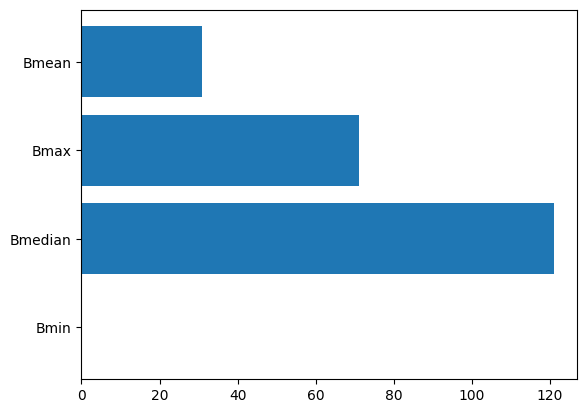

In [28]:
plt.barh(automl.model.estimator.feature_name_, automl.model.estimator.feature_importances_)

<BarContainer object of 2 artists>

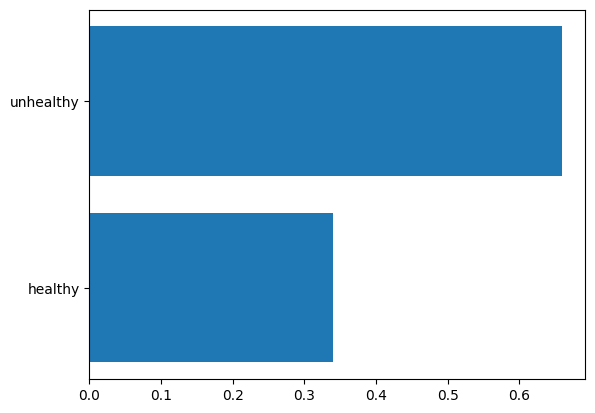

In [31]:
plt.barh(target_labels, probs[0])

In [32]:
print(automl.best_estimator)

lgbm


In [33]:
print(automl.best_config)

{'n_estimators': 29, 'num_leaves': 49, 'min_child_samples': 3, 'learning_rate': np.float64(0.020012475216299883), 'log_max_bin': 7, 'colsample_bytree': np.float64(0.3882066910744087), 'reg_alpha': np.float64(0.30358286355220176), 'reg_lambda': 0.0009765625}


In [34]:
with open("model.pkl", "wb") as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

In [52]:
with open("encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)

In [53]:
signal_no = load_signal('32')
s = compute_features(signal_no, 32, 16, 'hamming')
sa = np.array(s).reshape(1, -1)
sa

array([[3.90741004e-07, 3.54530685e-05, 5.36507306e-01, 1.10045871e-02]])

In [51]:
p = automl.predict_proba(sa)
pi = np.argmin(p, axis = 1)
encoder.inverse_transform(pi)
pi

array([0])

In [46]:
encoder.classes_

array(['healthy', 'unhealthy'], dtype=object)

In [54]:
automl.model.estimator.feature_importances_

array([  0, 121,  71,  31], dtype=int32)